In [1]:
#I utilize this script to answer questions from Assignment3 exercise1.
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#array of different flag you want to use to compile your fortran program.
flags = ["O0", "O1", "O2", "O3", "Ofast", "Oz"]

#define the largest dimension of the matrix
max_mat_dim = 1300
mat_dim_array = np.arange(100, max_mat_dim +1 , 100) 

#3darray, which entries correspond to (times in the 3 ways, matrix dimension, flag)
timesarray3d = np.zeros((3, len(mat_dim_array), len(flags)))

In [3]:
#function that compile an "input program" with "input flag": (O1,O2,O3,Of,...)".
def compile_with_flag(program_name, flag):
    subprocess.run(["gfortran", program_name, "-o", f"{program_name}-{flag}.out", f"-{flag}"])
#ouput is "program_name|.f90|-flag.out"    

In [4]:
for flag in flags:
    compile_with_flag("Different_Flags_Programs/Exercise3script.f90", f"{flag}") 

In [5]:
for i, flag in enumerate(flags): 
    for j, mat_dim in enumerate(mat_dim_array):
        output = subprocess.run([f"./Different_Flags_Programs/Exercise3script.f90-{flag}.out"], input="{}, {} \n {}, {} \n".format(mat_dim, mat_dim, mat_dim, mat_dim), 
                        stdout=subprocess.PIPE, encoding="utf-8")
        cpu_3_times = output.stdout.rstrip().split('\n')
        
        # component[0,j,i], [1,j,i], [2,j,i], correspond respectively to: 3loop-for usual matrix product,
        # 3loop-for inverted indices, matmul.
        timesarray3d[0, j, i] = float(cpu_3_times[0])
        timesarray3d[1, j, i] = float(cpu_3_times[1])
        timesarray3d[2, j, i] = float(cpu_3_times[2])

In [6]:
def plot_with_flag(flag, x, y1, y2, y_matmul):
    plt.figure(figsize=(10,5))
    plt.xlabel("matrices dimension")
    plt.ylabel("Cpu_time [s]")
    plt.title(f"Optimization -{flag}", loc = 'left')
    
    plt.plot(x, y1, 'r', label='Usual matrix product', marker = '.')
    plt.plot(x, y2, 'g', label='Inverted Indices', marker = '.')
    plt.plot(x, y_matmul, 'b', label='Matmul', marker = '.')

    plt.yscale("log")

    plt.legend()
    plt.savefig(f'Plots/Optimization -{flag}_mat_dim={max_mat_dim}.png')
    plt.show();#; should suppress the plot_output, it doesnt.
    
    plt.close()

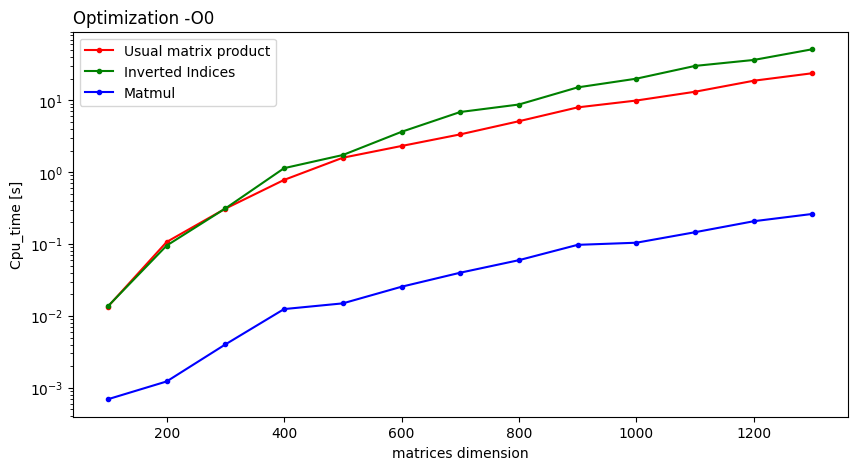

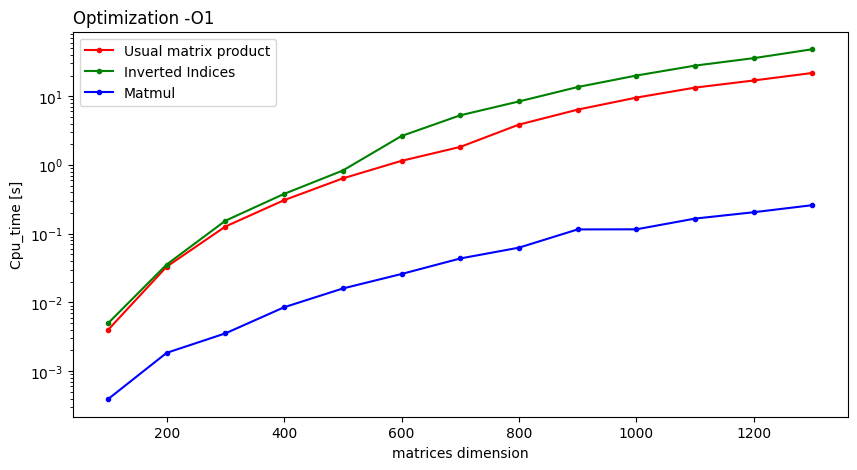

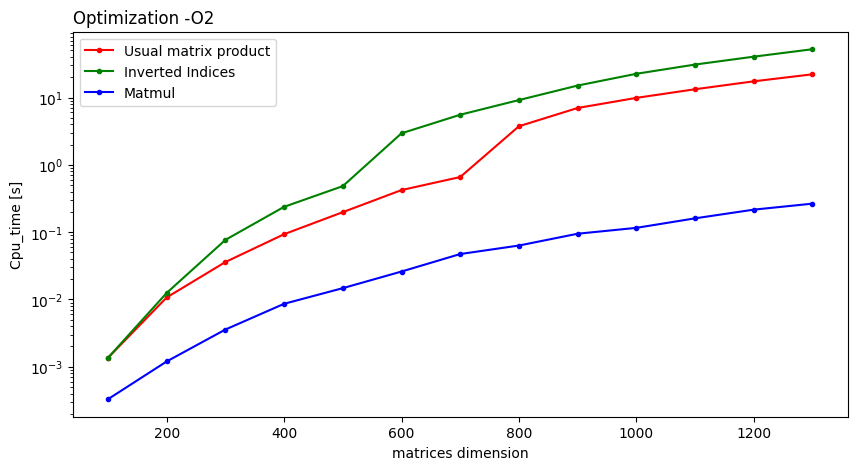

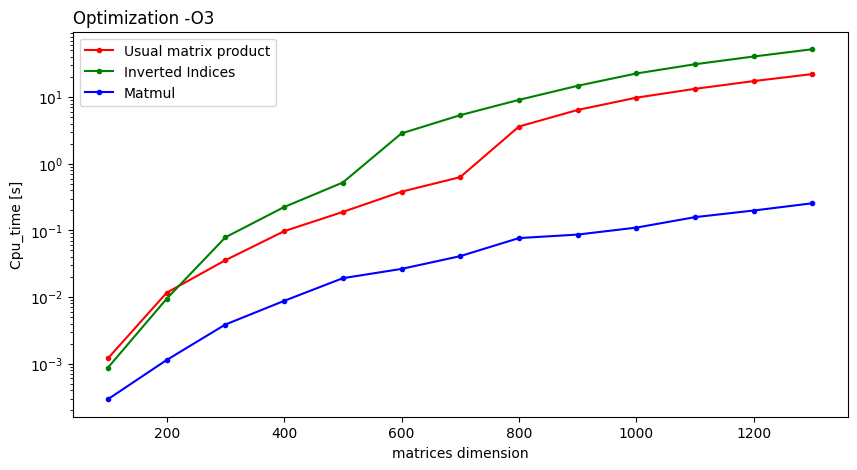

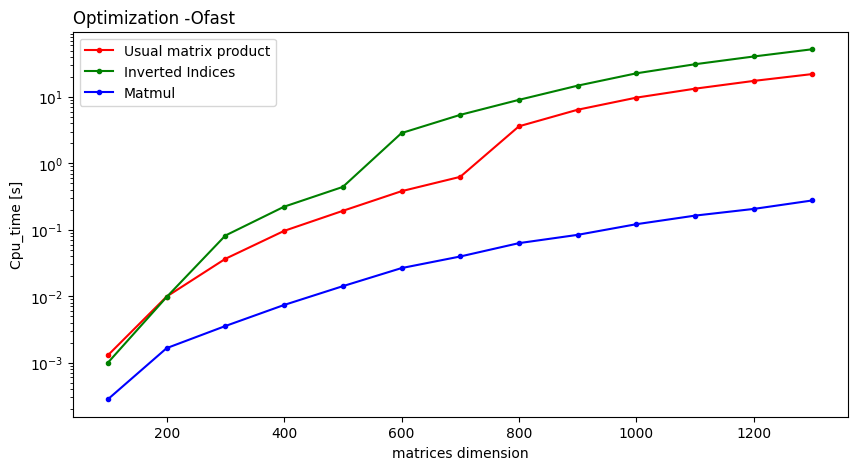

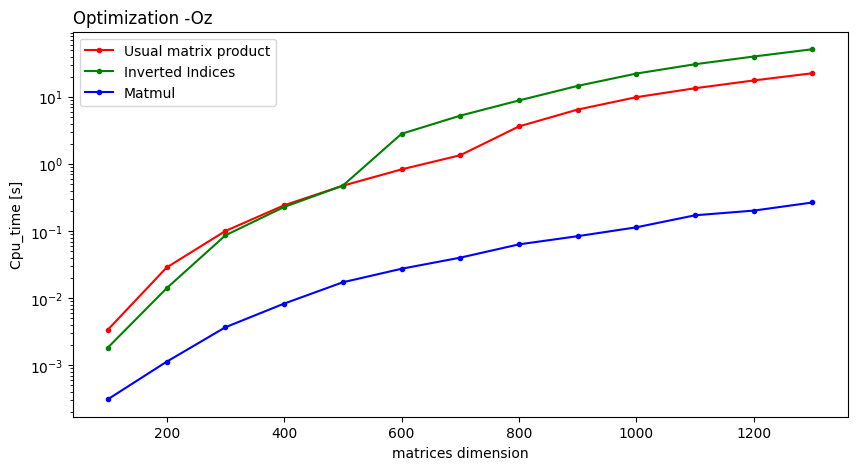

In [7]:
for i, flag in enumerate(flags):
    y1 = timesarray3d[0, :, i]
    y2 = timesarray3d[1, :, i]
    y_matmul = timesarray3d[2, :, i]
    plot_with_flag(flag, mat_dim_array, y1, y2, y_matmul)

In [8]:
def linear_fit(x_data, y_data):
    def linear_model(x, a, b):
        return a*x + b
    popt, pcov = curve_fit(linear_model, x_data, y_data)
    return popt, pcov

In [9]:
#Fitting with a 1o-polynomial the "Usual way, inverted indices and the matmul version to check the order of scaling"
x_dense = np.log(np.arange(100, max_mat_dim, 20))

y1_popt, y1_pcov = linear_fit(np.log(mat_dim_array), np.log(timesarray3d[0, :, 0])) 
y2_popt, y2_pcov = linear_fit(np.log(mat_dim_array), np.log(timesarray3d[1, :, 0]))
y_matmul_popt, y_matmul_pcov = linear_fit(np.log(mat_dim_array), np.log(timesarray3d[2, :, 0])) 

y1_fit = y1_popt[0]*x_dense + y1_popt[1]
y1_err = np.sqrt(np.diag(y1_pcov))
y2_fit = y2_popt[0]*x_dense + y2_popt[1]
y2_err = np.sqrt(np.diag(y2_pcov))
y_matmul_fit = y_matmul_popt[0]*x_dense + y_matmul_popt[1]
y_matmul_err = np.sqrt(np.diag(y_matmul_pcov))

#print(y1_popt, y1_pcov, y_matmul_popt, y_matmul_pcov)


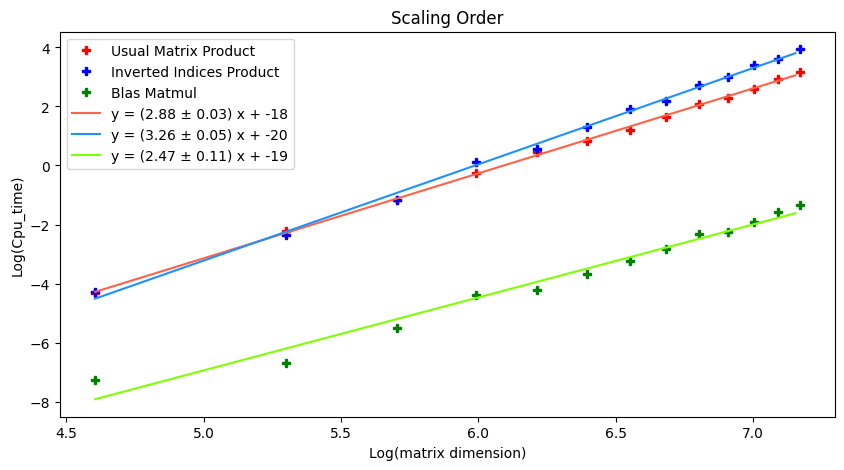

In [11]:
#Plot the logaritmic graph with slope corresponding to the scaling-order related to complexity,
#for the "usual" matrix product and for Blas one, using the Ofast-flag.   
plt.figure(figsize=(10,5))
plt.xlabel("Log(matrix dimension)")
plt.ylabel("Log(Cpu_time)")
plt.title("Scaling Order")

plt.plot(np.log(mat_dim_array), np.log(timesarray3d[0, :, 0]), 'r', marker='P', label = 'Usual Matrix Product', linestyle='None')
plt.plot(np.log(mat_dim_array), np.log(timesarray3d[1, :, 0]), 'b', marker='P', label = 'Inverted Indices Product', linestyle='None')
plt.plot(np.log(mat_dim_array), np.log(timesarray3d[2, :, 0]), 'g', marker='P', label = 'Blas Matmul', linestyle='None')

plt.plot(x_dense, y1_fit, 'tomato', label= f"y = ({y1_popt[0]:.2f} \u00B1 {y1_err[0]:.2f}) x + {y1_popt[1]:.0f}")
plt.plot(x_dense, y2_fit, 'dodgerblue', label= f"y = ({y2_popt[0]:.2f} \u00B1 {y2_err[0]:.2f}) x + {y2_popt[1]:.0f}")
plt.plot(x_dense, y_matmul_fit, 'chartreuse', label= f"y = ({y_matmul_popt[0]:.2f} \u00B1 {y_matmul_err[0]:.2f}) x + {y_matmul_popt[1]:.0f}")


plt.legend()
plt.savefig('Plots/scaling_order.png')
plt.show()

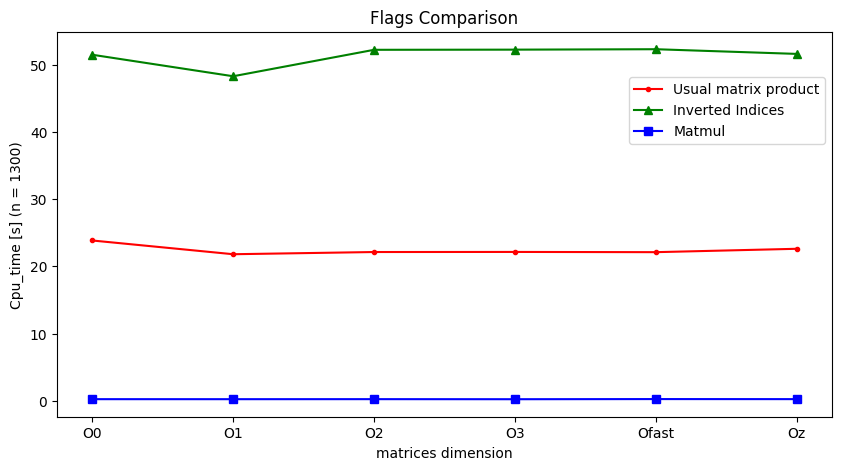

In [29]:
plt.figure(figsize=(10,5))
plt.xlabel("matrices dimension")
plt.ylabel("Cpu_time [s] (n = 1300)")
plt.title("Flags Comparison")
    
plt.plot(flags, timesarray3d[0,-1,:], 'r', label='Usual matrix product', marker = '.')
plt.plot(flags, timesarray3d[1,-1,:], 'g', label='Inverted Indices', marker = '^')
plt.plot(flags, timesarray3d[2,-1,:], 'b', label='Matmul', marker = 's')


plt.legend(bbox_to_anchor = [1, .9])
plt.savefig(f'Plots/Flags_comparison')
plt.show();#; should suppress the plot_output, it doesnt.
    
plt.close()
